# MiCoGPT v2.0 Fine-tuning (Sequence Classification)

本 Notebook 演示如何加载预训练好的 `MiCoGPT v2.0` 模型 (vCross 版)，并在下游任务 (例如疾病预测/二分类) 上进行微调。

**主要流程：**
1. 加载 `vCross` 版本的多模态语料库。
2. 筛选目标子集 (例如 Split_Group=A) 并准备分类标签。
3. 加载预训练模型，并转换为分类模型 (`MiCoGPTForSequenceClassification`)。
4. 使用自定义的 `MiCoGPTClassificationCollator` 处理多模态输入和分类标签。
5. 训练并评估。

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pickle import load as pkl_load
from argparse import Namespace
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from torch.utils.data import Subset
from transformers import Trainer, TrainingArguments
from transformers.trainer_callback import EarlyStoppingCallback

# --- v2.0 自定义模块 ---
from MiCoGPT.utils_vCross.model_vCross import MiCoGPTConfig, MiCoGPTForSequenceClassification
from MiCoGPT.utils_vCross.collator_vCross import MiCoGPTClassificationCollator

# --- 复用工具函数 ---
from MiCoGPT.utils.finetune import prepare_labels_for_subset, split_train_val_by_project_stratified_with_labels
from MiCoGPT.utils.finetune_v2 import SubsetWithLabels

import warnings
warnings.filterwarnings("ignore")

## 1. 配置参数 (Configuration)

设置输入数据路径、预训练模型路径和微调参数。

In [2]:
args = Namespace(
    # 输入语料库 (vCross 格式)
    input="../data/vCross/ResMicroDB_90338_vCross.pkl",
    
    # 预训练模型路径 (从 checkpoint 加载)
    pretrained_model="../models/pretrain_vCross_base",
    
    # output="../models/finetuned_vCross_base",
    # log="../logs/finetuned_vCross_base",
    
    output="../models/finetuned_vCross_base_valLoss",
    log="../logs/finetuned_vCross_base_valLoss",
    
    # 任务相关
    label_col="Is_Healthy",     # 预测标签列
    split_group="A",            # 仅使用 Split_Group A 进行微调
    val_ratio=0.2,              # 验证集比例
)

print("Args:", args)

Args: Namespace(input='../data/vCross/ResMicroDB_90338_vCross.pkl', pretrained_model='../models/pretrain_vCross_base', output='../models/finetuned_vCross_base_valLoss', log='../logs/finetuned_vCross_base_valLoss', label_col='Is_Healthy', split_group='A', val_ratio=0.2)


## 2. 加载语料库 (Load Corpus)

读取 `MiCoGPTCorpus_vCross` 对象，包含多模态数据 (Token IDs, Value IDs, Condition IDs) 和元数据 (Metadata)。

In [3]:
print(f"Loading corpus from {args.input} ...")
with open(args.input, "rb") as f:
    corpus = pkl_load(f)
    
print(f"Loaded corpus with {len(corpus)} samples.")
print("Tokenizer vocab size:", corpus.tokenizer.vocab_size)

Loading corpus from ../data/vCross/ResMicroDB_90338_vCross.pkl ...
Loaded corpus with 90338 samples.
Tokenizer vocab size: 1121


## 3. 数据准备 (Data Preparation)

1. **筛选子集**: 选择 `Split_Group == A` 且标签存在的样本。
2. **生成标签**: 将文本标签 (如 True/False) 转换为数字 ID。
3. **划分数据集**: 按 Project 对应的 Study 进行分层划分，防止数据泄漏。

In [4]:
# 1. 筛选子集
meta = corpus.metadata
valid_mask = (meta["Split_Group"] == args.split_group) & (meta[args.label_col].notna())
finetune_indices = np.where(valid_mask)[0]
finetune_subset = Subset(corpus, finetune_indices)

print(f"Filtered subset size: {len(finetune_subset)}")

# 2. 生成标签 (prepare_labels_for_subset 来自 MiCoGPT.utils.finetune)
# 它会返回一个与 corpus 长度对齐的 all_labels 数组 (非 subset 位置为 -1)
labels_tensor, all_labels_array, le, num_labels = prepare_labels_for_subset(
    all_corpus=corpus,
    subset=finetune_subset,
    label_col=args.label_col,
    verbose=True
)

# 3. 划分训练/验证集
train_subset, val_subset = split_train_val_by_project_stratified_with_labels(
    finetune_subset,
    label_col=args.label_col,
    val_ratio=args.val_ratio,
    project_col="Project_ID"
)

print(f"Train size: {len(train_subset)}")
print(f"Val size: {len(val_subset)}")

Filtered subset size: 55575
[labels] subset size=55575
[labels] num_labels=2
[labels] distribution:
0    31073
1    24502
Name: count, dtype: int64
[split] total_samples=55575, target_val~11115
[split] eligible_projects=251, eligible_samples=55398
[split] ineligible_projects=16, ineligible_samples=177
[split] label_dist (overall):
Is_Healthy
False    31073
True     24502
Name: count, dtype: int64
[split] actual_val=11115 (target~11115), train=44460
[split] label_dist (val):
Is_Healthy
False    6109
True     5006
Name: count, dtype: int64
Train size: 44460
Val size: 11115


In [5]:
# 4. 包装成带 Labels 的 Dataset
def create_dataset_with_labels(subset, all_labels_array):
    # subset.indices 是在 corpus 中的全局索引
    indices = subset.indices
    # 从全局 labels 数组中提取对应标签
    subset_labels = torch.tensor(all_labels_array[indices], dtype=torch.long)
    return SubsetWithLabels(subset, subset_labels)

train_ds = create_dataset_with_labels(train_subset, all_labels_array)
val_ds = create_dataset_with_labels(val_subset, all_labels_array)

# 检查一个样本
sample = train_ds[0]
print("Sample keys:", sample.keys())
print("Label:", sample["labels"])

Sample keys: dict_keys(['input_ids', 'value_ids', 'condition_ids', 'attention_mask', 'labels'])
Label: tensor(0)


## 4. 加载模型 (Load Model)

加载预训练的 `vCross` 模型，并实例化为 `MiCoGPTForSequenceClassification`。
注意：
- 我们需要指定 `num_labels`。
- `ignore_mismatched_sizes=True` 是必须的，因为分类头 (Score Layer) 是新初始化的，与预训练的 LM Head 尺寸不同。

In [6]:
# 加载配置
config = MiCoGPTConfig.from_pretrained(args.pretrained_model)
config.num_labels = num_labels
print("Model Config:", config)

# 加载模型
model = MiCoGPTForSequenceClassification.from_pretrained(
    args.pretrained_model,
    config=config,
    ignore_mismatched_sizes=True
)

# 打印模型结构，确认多模态 Embedding 和分类头存在
print(model)

Some weights of MiCoGPTForSequenceClassification were not initialized from the model checkpoint at ../models/pretrain_vCross_base and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of MiCoGPTForSequenceClassification were not initialized from the model checkpoint at ../models/pretrain_vCross_base and are newly initialized because the shapes did not match:
- prior_matrix: found shape torch.Size([1121, 256]) in the checkpoint and torch.Size([1, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Config: MiCoGPTConfig {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "MiCoGPTForCausalLM"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 2,
  "condition_vocab_sizes": [
    11
  ],
  "embd_pdrop": 0.1,
  "eos_token_id": 3,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 256,
  "n_head": 8,
  "n_inner": null,
  "n_layer": 8,
  "n_positions": 512,
  "num_bins": 52,
  "pad_token_id": 0,
  "prior_matrix_path": "/home/cml_lab/caiqy/project/MiCoGPT/MiCoGPT/resources/genus_embeddings_256.npz",
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.33.3",
  "use_cache": true,
  "vocab_size": 1121
}

MiCoGPTForSeq

## 5. 训练 (Training)

使用 HuggingFace Trainer 进行微调。
- 使用 `MiCoGPTClassificationCollator` 处理数据。
- 定义评估指标 (Accuracy, F1)。

In [7]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    
    return {
        "accuracy": acc,
        "f1": f1
    }

In [8]:
training_args = TrainingArguments(
    output_dir=args.output,
    num_train_epochs=100,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    
    learning_rate=1e-5,
    weight_decay=0.01,
    
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    
    logging_dir=args.log,
    logging_steps=50,
    
    # NFS 优化
    dataloader_num_workers=0,
    
    # 显存优化 (防止 Evaluation OOM)
    # eval_accumulation_steps=60,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    # 使用自定义的分类 Collator
    data_collator=MiCoGPTClassificationCollator(corpus.tokenizer, max_length=512),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

In [ ]:
# --- [New] 手动测试 Step 0 的 Validation Loss ---
print("Evaluating initial model (Step 0) ...")

# 调用 evaluate() 会使用 Trainer 初始化时传入的 eval_dataset 进行评估
init_eval_metrics = trainer.evaluate()

print("Initial Eval Metrics:", init_eval_metrics)

In [9]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.264500,0.263851,0.895726,0.895396
2,0.196900,0.199389,0.919478,0.919315
3,0.173900,0.171607,0.931174,0.931123
4,0.148200,0.156314,0.939091,0.939051
5,0.140700,0.144946,0.942870,0.942824
6,0.126600,0.138368,0.947009,0.946978
7,0.126300,0.132759,0.948808,0.948776
8,0.104300,0.129218,0.950697,0.950688
9,0.092500,0.128764,0.950247,0.950232
10,0.087100,0.126223,0.951957,0.951939


TrainOutput(global_step=40310, training_loss=0.09422301737361971, metrics={'train_runtime': 6818.5943, 'train_samples_per_second': 652.041, 'train_steps_per_second': 20.385, 'total_flos': 3.338421940518912e+16, 'train_loss': 0.09422301737361971, 'epoch': 29.0})

## 6. 保存与分析 (Save & Analyze)

保存微调后的模型、Tokenizer 以及训练日志。

In [10]:
# 1. 保存模型
trainer.save_model(args.output)
corpus.tokenizer.save_pretrained(args.output)

# 保存 Label Encoder (关键)
import joblib
joblib.dump(le, f"{args.output}/label_encoder.joblib")
print(f"Model and LabelEncoder saved to {args.output}")

# 2. 导出日志
log_history = trainer.state.log_history
with open(f"{args.output}/training_logs.json", "w") as f:
    json.dump(log_history, f, indent=2)

# 3. 绘制曲线
train_steps = [x["step"] for x in log_history if "loss" in x]
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_steps = [x["step"] for x in log_history if "eval_loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]
eval_f1 = [x["eval_f1"] for x in log_history if "eval_f1" in x]

plt.figure(figsize=(12, 5))

# Loss 曲线
plt.subplot(1, 2, 1)
if train_steps: plt.plot(train_steps, train_loss, label="Train Loss", alpha=0.6)
if eval_steps: plt.plot(eval_steps, eval_loss, label="Val Loss", marker="o")
plt.title("Loss Curve")
plt.legend()

# F1 曲线
plt.subplot(1, 2, 2)
if eval_steps and eval_f1: 
    plt.plot(eval_steps, eval_f1, label="Val F1", color="orange", marker="s")
plt.title("F1 Score Curve")
plt.legend()

plt.savefig(f"{args.output}/training_curve.png")
plt.show()

NotImplementedError: 

Model and LabelEncoder saved to ../models/finetuned_vCross_base


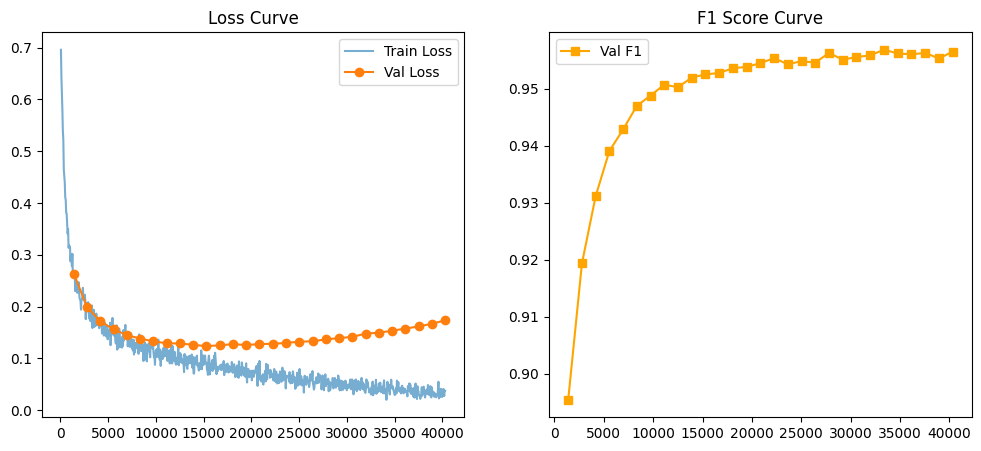

In [10]:
# 1. 保存模型
trainer.save_model(args.output)

# [Patch] Tokenizer 保存补丁
# 尝试使用标准 save_pretrained，如果报错(NotImplementedError)，则使用 joblib 备份
try:
    corpus.tokenizer.save_pretrained(args.output)
    print(f"Tokenizer saved to {args.output} via save_pretrained")
except NotImplementedError:
    import joblib
    print("Warning: Tokenizer.save_pretrained not implemented. Saving tokenizer object via joblib instead.")
    joblib.dump(corpus.tokenizer, f"{args.output}/tokenizer.joblib")
except Exception as e:
    # 兜底：任何其他错误也尝试用 joblib 救一下
    import joblib
    print(f"Warning: Failed to save tokenizer via save_pretrained ({e}). Saving via joblib.")
    joblib.dump(corpus.tokenizer, f"{args.output}/tokenizer.joblib")

# 保存 Label Encoder (关键)
import joblib
joblib.dump(le, f"{args.output}/label_encoder.joblib")
print(f"Model and LabelEncoder saved to {args.output}")

# 2. 导出日志
log_history = trainer.state.log_history
import json
with open(f"{args.output}/training_logs.json", "w") as f:
    json.dump(log_history, f, indent=2)

# 3. 绘制曲线
train_steps = [x["step"] for x in log_history if "loss" in x]
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_steps = [x["step"] for x in log_history if "eval_loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]
eval_f1 = [x["eval_f1"] for x in log_history if "eval_f1" in x]

plt.figure(figsize=(12, 5))

# Loss 曲线
plt.subplot(1, 2, 1)
if train_steps: plt.plot(train_steps, train_loss, label="Train Loss", alpha=0.6)
if eval_steps: plt.plot(eval_steps, eval_loss, label="Val Loss", marker="o")
plt.title("Loss Curve")
plt.legend()

# F1 曲线
plt.subplot(1, 2, 2)
if eval_steps and eval_f1: 
    plt.plot(eval_steps, eval_f1, label="Val F1", color="orange", marker="s")
plt.title("F1 Score Curve")
plt.legend()

plt.savefig(f"{args.output}/training_curve.png")
plt.show()

## 7.5. (可选) 重载模型 (Reload Model)

如果内存已清空，可以运行此 Cell 重载模型。

In [4]:
# 0. (可选) 重新加载模型和配置

import joblib
from MiCoGPT.utils_vCross.model_vCross import MiCoGPTConfig, MiCoGPTForSequenceClassification

def create_dataset_with_labels(subset, all_labels_array):
    # subset.indices 是在 corpus 中的全局索引
    indices = subset.indices
    # 从全局 labels 数组中提取对应标签
    subset_labels = torch.tensor(all_labels_array[indices], dtype=torch.long)
    return SubsetWithLabels(subset, subset_labels)

# 检查变量是否存在，如果不存在则加载
if 'trainer' not in locals() or 'model' not in locals() or 'le' not in locals():
    print(f"Loading model from {args.output} ...")
    
    # 1. 加载 Label Encoder
    le_path = f"{args.output}/label_encoder.joblib"
    if os.path.exists(le_path):
        le = joblib.load(le_path)
        print("Label Encoder loaded.")
    else:
        raise FileNotFoundError(f"Label Encoder not found at {le_path}. Please run training first.")
    
    # 2. 加载模型
    if hasattr(le, "classes_"):
        num_labels = len(le.classes_)
    else:
        num_labels = len(le.categories_[0])
        
    config = MiCoGPTConfig.from_pretrained(args.output)
    model = MiCoGPTForSequenceClassification.from_pretrained(args.output, config=config)
    
    # 3. 准备 Collator
    if 'MiCoGPTClassificationCollator' not in locals():
        from MiCoGPT.utils_vCross.collator_vCross import MiCoGPTClassificationCollator
        
    if 'corpus' in locals():
        tokenizer = corpus.tokenizer
    else:
        print("Warning: corpus not in memory. Using tokenizer from saved model.")
        raise ValueError("Please run the 'Load Corpus' cell above to load the tokenizer first.")
        
    data_collator = MiCoGPTClassificationCollator(tokenizer)
    
    # 4. 重建 Trainer
    trainer = Trainer(
        model=model,
        args=TrainingArguments(output_dir=args.output, per_device_eval_batch_size=32),
        data_collator=data_collator
    )
    print("Model and Trainer restored.")
else:
    print("Model and Trainer already in memory. Skipping reload.")

Loading model from ../models/finetuned_vCross_base ...
Label Encoder loaded.
Model and Trainer restored.


## 8. 预测 (Prediction on Split B)

使用微调后的模型对测试集 (Split_Group='B') 进行预测，并调用 `eval_and_save` 计算多项指标。

In [5]:
from MiCoGPT.utils.mgm_utils import eval_and_save

# 1. 准备测试集 (Split_Group = B)
print("Preparing Test Set (Split_Group='B')...")
meta = corpus.metadata
test_mask = (meta["Split_Group"] == "B") & (meta[args.label_col].notna())
test_indices = np.where(test_mask)[0]
test_subset = Subset(corpus, test_indices)

print(f"Test subset size: {len(test_subset)}")

# 2. 生成测试集标签 (复用训练时的 Encoder)
# 注意：这里必须传入训练时 fit 好的 le (encoder)，以保证标签 ID 映射一致
test_labels_tensor, test_all_labels, _, _ = prepare_labels_for_subset(
    all_corpus=corpus,
    subset=test_subset,
    label_col=args.label_col,
    encoder=le, 
    verbose=True
)

# 3. 包装 Dataset
test_ds = create_dataset_with_labels(test_subset, test_all_labels)

# 4. 预测
print("Running prediction...")
# Trainer 会自动使用最佳模型 (load_best_model_at_end=True)
predictions = trainer.predict(test_ds)
y_score = predictions.predictions
y_true = predictions.label_ids

# 5. 评估并保存
# 获取类别名称
if hasattr(le, "categories_"):
    # OneHotEncoder
    label_names = list(le.categories_[0])
else:
    # LabelEncoder
    label_names = [str(c) for c in le.classes_]

save_dir = f"{args.output}/prediction_B"
os.makedirs(save_dir, exist_ok=True)

print(f"Saving results to {save_dir}...")
eval_and_save(
    y_score=y_score,
    y_true=y_true,
    label_names=label_names,
    save_dir=save_dir,
    activation="softmax" # 模型输出 logits，需要 softmax 归一化
)

Preparing Test Set (Split_Group='B')...
Test subset size: 13901
[labels] subset size=13901
[labels] num_labels=2
[labels] distribution:
0    7776
1    6125
Name: count, dtype: int64
Running prediction...


Saving results to ../models/finetuned_vCross_base/prediction_B...
Evaluating biome source: False
         TN    FP    FN    TP     Acc      Sn      Sp     TPR     FPR      Rc  \
t                                                                               
0.000     0  6125     0  7776  0.5594  1.0000  0.0000  1.0000  1.0000  1.0000   
0.001   531  5594   188  7588  0.5841  0.9758  0.0867  0.9758  0.9133  0.9758   
0.002   635  5490   239  7537  0.5879  0.9693  0.1037  0.9693  0.8963  0.9693   
0.003   694  5431   276  7500  0.5895  0.9645  0.1133  0.9645  0.8867  0.9645   
0.004   735  5390   301  7475  0.5906  0.9613  0.1200  0.9613  0.8800  0.9613   
...     ...   ...   ...   ...     ...     ...     ...     ...     ...     ...   
0.997  3525  2600  2056  5720  0.6651  0.7356  0.5755  0.7356  0.4245  0.7356   
0.998  3728  2397  2169  5607  0.6715  0.7211  0.6087  0.7211  0.3913  0.7211   
0.999  4048  2077  2400  5376  0.6779  0.6914  0.6609  0.6914  0.3391  0.6914   
1.000  6125 

,Acc,Sn,Sp,TPR,FPR,Rc,Pr,F1,F-max,ROC-AUC,PR-AUC
0,0.5000,1.0000,0.0000,1.0000,1.0000,1.0000,0.5000,0.6646,0.6846,0.6837,0.5172
1,0.6310,0.8184,0.3890,0.8184,0.6110,0.8184,0.6017,0.6840,0.6846,0.6837,0.5172
2,0.6297,0.7890,0.4124,0.7890,0.5876,0.7890,0.6054,0.6724,0.6846,0.6837,0.5172
3,0.6273,0.7700,0.4244,0.7700,0.5756,0.7700,0.6058,0.6634,0.6846,0.6837,0.5172
4,0.6264,0.7581,0.4332,0.7581,0.5668,0.7581,0.6070,0.6579,0.6846,0.6837,0.5172
...,...,...,...,...,...,...,...,...,...,...,...
997,0.6273,0.4244,0.7700,0.4244,0.2300,0.4244,0.7015,0.4532,0.6846,0.6837,0.5172
998,0.6297,0.4124,0.7890,0.4124,0.2110,0.4124,0.7135,0.4460,0.6846,0.6837,0.5172
999,0.6310,0.3890,0.8184,0.3890,0.1816,0.3890,0.7299,0.4306,0.6846,0.6837,0.5172
1000,0.5000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,NaN,0.6846,0.6837,0.5172


In [4]:
# 0. (可选) 重新加载模型和配置

import joblib
from MiCoGPT.utils_vCross.model_vCross import MiCoGPTConfig, MiCoGPTForSequenceClassification

def create_dataset_with_labels(subset, all_labels_array):
    # subset.indices 是在 corpus 中的全局索引
    indices = subset.indices
    # 从全局 labels 数组中提取对应标签
    subset_labels = torch.tensor(all_labels_array[indices], dtype=torch.long)
    return SubsetWithLabels(subset, subset_labels)

# 检查变量是否存在，如果不存在则加载
if 'trainer' not in locals() or 'model' not in locals() or 'le' not in locals():
    print(f"Loading model from {args.output} ...")
    
    # 1. 加载 Label Encoder
    le_path = f"{args.output}/label_encoder.joblib"
    if os.path.exists(le_path):
        le = joblib.load(le_path)
        print("Label Encoder loaded.")
    else:
        raise FileNotFoundError(f"Label Encoder not found at {le_path}. Please run training first.")
    
    # 2. 加载模型
    if hasattr(le, "classes_"):
        num_labels = len(le.classes_)
    else:
        num_labels = len(le.categories_[0])
        
    config = MiCoGPTConfig.from_pretrained(args.output)
    model = MiCoGPTForSequenceClassification.from_pretrained(args.output, config=config)
    
    # 3. 准备 Collator
    if 'MiCoGPTClassificationCollator' not in locals():
        from MiCoGPT.utils_vCross.collator_vCross import MiCoGPTClassificationCollator
        
    if 'corpus' in locals():
        tokenizer = corpus.tokenizer
    else:
        print("Warning: corpus not in memory. Using tokenizer from saved model.")
        raise ValueError("Please run the 'Load Corpus' cell above to load the tokenizer first.")
        
    data_collator = MiCoGPTClassificationCollator(tokenizer)
    
    # 4. 重建 Trainer
    trainer = Trainer(
        model=model,
        args=TrainingArguments(output_dir=args.output, per_device_eval_batch_size=32),
        data_collator=data_collator
    )
    print("Model and Trainer restored.")
else:
    print("Model and Trainer already in memory. Skipping reload.")

Loading model from ../models/finetuned_vCross_base_valLoss ...
Label Encoder loaded.
Model and Trainer restored.


In [5]:
from MiCoGPT.utils.mgm_utils import eval_and_save

# 1. 准备测试集 (Split_Group = B)
print("Preparing Test Set (Split_Group='B')...")
meta = corpus.metadata
test_mask = (meta["Split_Group"] == "B") & (meta[args.label_col].notna())
test_indices = np.where(test_mask)[0]
test_subset = Subset(corpus, test_indices)

print(f"Test subset size: {len(test_subset)}")

# 2. 生成测试集标签 (复用训练时的 Encoder)
# 注意：这里必须传入训练时 fit 好的 le (encoder)，以保证标签 ID 映射一致
test_labels_tensor, test_all_labels, _, _ = prepare_labels_for_subset(
    all_corpus=corpus,
    subset=test_subset,
    label_col=args.label_col,
    encoder=le, 
    verbose=True
)

# 3. 包装 Dataset
test_ds = create_dataset_with_labels(test_subset, test_all_labels)

# 4. 预测
print("Running prediction...")
# Trainer 会自动使用最佳模型 (load_best_model_at_end=True)
predictions = trainer.predict(test_ds)
y_score = predictions.predictions
y_true = predictions.label_ids

# 5. 评估并保存
# 获取类别名称
if hasattr(le, "categories_"):
    # OneHotEncoder
    label_names = list(le.categories_[0])
else:
    # LabelEncoder
    label_names = [str(c) for c in le.classes_]

save_dir = f"{args.output}/prediction_B"
os.makedirs(save_dir, exist_ok=True)

print(f"Saving results to {save_dir}...")
eval_and_save(
    y_score=y_score,
    y_true=y_true,
    label_names=label_names,
    save_dir=save_dir,
    activation="softmax" # 模型输出 logits，需要 softmax 归一化
)

Preparing Test Set (Split_Group='B')...
Test subset size: 13901
[labels] subset size=13901
[labels] num_labels=2
[labels] distribution:
0    7776
1    6125
Name: count, dtype: int64
Running prediction...


Saving results to ../models/finetuned_vCross_base_valLoss/prediction_B...
Evaluating biome source: False
           TN    FP    FN    TP     Acc   Sn   Sp  TPR  FPR   Rc      Pr  \
t                                                                          
0.00000     0  6125     0  7776  0.5594  1.0  0.0  1.0  1.0  1.0  0.5594   
0.00001     0  6125     0  7776  0.5594  1.0  0.0  1.0  1.0  1.0  0.5594   
0.00002     0  6125     0  7776  0.5594  1.0  0.0  1.0  1.0  1.0  0.5594   
0.00003     0  6125     0  7776  0.5594  1.0  0.0  1.0  1.0  1.0  0.5594   
0.00004     0  6125     0  7776  0.5594  1.0  0.0  1.0  1.0  1.0  0.5594   
...       ...   ...   ...   ...     ...  ...  ...  ...  ...  ...     ...   
0.99997  6125     0  7776     0  0.4406  0.0  1.0  0.0  0.0  0.0  0.0000   
0.99998  6125     0  7776     0  0.4406  0.0  1.0  0.0  0.0  0.0  0.0000   
0.99999  6125     0  7776     0  0.4406  0.0  1.0  0.0  0.0  0.0  0.0000   
1.00000  6125     0  7776     0  0.4406  0.0  1.0  0.0  0.0

,Acc,Sn,Sp,TPR,FPR,Rc,Pr,F1,F-max,ROC-AUC,PR-AUC
0,0.5,1.0,0.0,1.0,1.0,1.0,0.5,0.6646,0.7262,0.7544,0.7371
1,0.5,1.0,0.0,1.0,1.0,1.0,0.5,0.6646,0.7262,0.7544,0.7371
2,0.5,1.0,0.0,1.0,1.0,1.0,0.5,0.6646,0.7262,0.7544,0.7371
3,0.5,1.0,0.0,1.0,1.0,1.0,0.5,0.6646,0.7262,0.7544,0.7371
4,0.5,1.0,0.0,1.0,1.0,1.0,0.5,0.6646,0.7262,0.7544,0.7371
...,...,...,...,...,...,...,...,...,...,...,...
99997,0.5,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.7262,0.7544,0.7371
99998,0.5,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.7262,0.7544,0.7371
99999,0.5,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.7262,0.7544,0.7371
100000,0.5,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.7262,0.7544,0.7371
